# Imports

In [1]:
# Qsurface imports
from qsurface.main import create_phenomenological_toric_superoperator, create_phenomenological_weight_3_toric_superoperator,create_phenomenological_weight_4_toric_superoperator, initialize, run, BenchmarkDecoder, run_multiprocess_superoperator


# Interactive plotting imports
from bokeh.plotting import figure, show
from bokeh.models import Label
from bokeh.util.compiler import TypeScript

# Plotting imports
import matplotlib.pyplot as plt

# Math imports
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import math

# Utilities import
from os import listdir
from os.path import isfile, join
from itertools import permutations
import timeit
import time


%load_ext line_profiler

# CSVs Correction

In [ ]:
''' This block creates a separate dataframe and fills it up with the new combination of error string and uses
the rest same values. And merges them later with a resetted index.'''
files = [f for f in listdir("C:/qarch/qsurface/data/monolithic") if isfile(join("C:/qarch/qsurface/data/monolithic", f))]
new_location = ["C:/qarch/qsurface/data/monolithic/normalized/"+ f for f in files]
FILES = ["C:/qarch/qsurface/data/monolithic/"+ f for f in files]

for new_loc, location in zip(new_location, FILES):
    data = pd.read_csv(location, sep=';')

    data2 = pd.DataFrame(columns=data.columns)
    for index, row in data.iterrows():
        perms = [''.join(p) for p in set(permutations(row["error_config"]))]
        for permutation in perms:
            if permutation == row["error_config"]:
                continue
            else:
                data2.loc[data2.shape[0]] = [permutation, row['lie'], row['p'], row['s'],0,0,0,0,0,0,0,0,0,0,0,0,0]

    data_merged = pd.concat([data, data2]).reset_index()
    del data_merged['index']

    '''Now we need to rescale the error permutation star and plaquette weights. And later normalize the whole superoperator.'''
    # Finding the right weights

    for index, row in data.iterrows():
        perms = [''.join(p) for p in set(permutations(row["error_config"]))]
        n_perms = len(perms)

        for index_f, row_f in data_merged.iterrows():
            if row_f['error_config'] in perms and row_f['lie'] == row['lie']:
                data_merged.loc[index_f,'p'] = row_f['p']/n_perms
                data_merged.loc[index_f,'s'] = row_f['s']/n_perms

    # Normalizing the whole CSV weights

    psum = data_merged['p'].sum()
    ssum = data_merged['s'].sum()

    data_merged['p'] = data_merged['p'].div(psum)
    data_merged['s'] = data_merged['s'].div(ssum)

    data_merged.to_csv(new_loc, sep=';', index=False)

# Create phenomenological superoperators

In [14]:
error_rates = [float(round(x,3)) for x in np.linspace(0.0, 0.12, 30)]
print(error_rates)
for rate in error_rates:
    # index = time.strftime("%Y%m%d_%H%M%S")
    create_phenomenological_weight_4_toric_superoperator(1,[rate, rate, 0, 0])
    # create_phenomenological_weight_3_toric_superoperator(1,[rate, rate, rate, rate, 0, 0])
    # create_phenomenological_toric_superoperator([rate, rate, 0, 0])


[0.0, 0.004, 0.008, 0.012, 0.017, 0.021, 0.025, 0.029, 0.033, 0.037, 0.041, 0.046, 0.05, 0.054, 0.058, 0.062, 0.066, 0.07, 0.074, 0.079, 0.083, 0.087, 0.091, 0.095, 0.099, 0.103, 0.108, 0.112, 0.116, 0.12]


In [8]:
rate = 0.83
create_phenomenological_toric_superoperator([rate, rate, rate, rate])
# create_phenomenological_weight_3_toric_superoperator(1,[rate, rate, rate, rate, rate, rate])
# create_phenomenological_weight_4_toric_superoperator(1,[rate, rate, rate, rate])

# Time Scaling of Implementation

## Superoperator Mechanism

In [ ]:
file_location = "./data/weight_3_phenomenological/"
export_location = './data/weight_3_phenomenological/exported_data/time_scaling_weight3.json'
iters = 100


SIZE = [(4,4), (6,6), (8,8), (10,10), (12,12), (14,14), (16,16)]
files = [f for f in listdir(file_location) if isfile(join(file_location, f))]
FILES = [file_location + f for f in files]
N_RATE = len(FILES)

time_comp = {}
for serial in range(N_RATE):
    time_comp[serial] = []


for super, serial in zip(FILES, range(N_RATE)):
    for size in SIZE:
        start = timeit.default_timer()
        code, decoder = initialize(size, "weight_3_toric", "unionfind", plotting=False, superoperator_enable=True, sup_op_file=super, initial_states=(0,0))
        run(code, decoder, iterations=iters, decode_initial=False)
        stop = timeit.default_timer()
        duration = stop - start

        time_comp[serial].append(duration/iters)

print(time_comp)
export_data = pd.DataFrame(time_comp)

export_data.to_json(export_location)

## Original phenomenological implementation

In [ ]:
export_location = './data/exported_data/time_scaling.json'
iters = 1000


SIZE = [(4,4), (6,6), (8,8), (10,10), (12,12), (14,14), (16,16)]
ERRORS = [{"p_bitflip": 0.005, "p_phaseflip": 0.005, "p_bitflip_plaq": 0.005, "p_bitflip_star": 0.005},
{"p_bitflip": 0.01, "p_phaseflip": 0.01, "p_bitflip_plaq": 0.01, "p_bitflip_star": 0.01},
{"p_bitflip": 0.015, "p_phaseflip": 0.015, "p_bitflip_plaq": 0.015, "p_bitflip_star": 0.015},
{"p_bitflip": 0.02, "p_phaseflip": 0.02, "p_bitflip_plaq": 0.02, "p_bitflip_star": 0.02},
{"p_bitflip": 0.025, "p_phaseflip": 0.025, "p_bitflip_plaq": 0.025, "p_bitflip_star": 0.025},
{"p_bitflip": 0.03, "p_phaseflip": 0.03, "p_bitflip_plaq": 0.03, "p_bitflip_star": 0.03},
{"p_bitflip": 0.035, "p_phaseflip": 0.035, "p_bitflip_plaq": 0.035, "p_bitflip_star": 0.035},
{"p_bitflip": 0.04, "p_phaseflip": 0.04, "p_bitflip_plaq": 0.04, "p_bitflip_star": 0.04}
]
N_RATE = len(ERRORS)

time_comp = {}
for serial in range(N_RATE):
    time_comp[serial] = []


for error, serial in zip(ERRORS, range(N_RATE)):
    for size in SIZE:
        start = timeit.default_timer()
        code, decoder = initialize(size, "toric", "unionfind", enabled_errors=["pauli"],faulty_measurements=True, initial_states=(0,0))
        run(code, decoder, iterations=iters, error_rates=error, decode_initial=False)
        stop = timeit.default_timer()
        duration = stop - start

        time_comp[serial].append(duration/iters)

print(time_comp)
export_data = pd.DataFrame(time_comp)

export_data.to_json(export_location)

# Different Architecture Comparisons for phenomenological noise

## Monolithic comparison Phenomeological: Inbuilt vs Superoperator

### Superoperator

In [2]:
create_phenomenological_toric_superoperator([0.03,0.03,0.03,0.03])

In [5]:
code, decoder = initialize((4,4), "toric", "unionfind", plotting=False, superoperator_enable=True, sup_op_file="phenomenological_0.03_0.03_0.03_0.03_toric.csv", initial_states=(0,0))
benchmarker = BenchmarkDecoder({
        "decode": ["duration", "value_to_list"],
        "correct_edge": "count_calls",})
print(run(code, decoder, iterations=1000, decode_initial=False, benchmark=benchmarker))

# %lprun -f code.init_superoperator_errors run(code, decoder, iterations=4, decode_initial=False)

Running iteration 1000/1000
{'no_error': 754, 'benchmark': {'decoded': 999, 'iterations': 1000, 'seed': 749.6737757, 'duration/decode/mean': 0.0014002708999995548, 'duration/decode/std': 0.0011852075302904617, 'count_calls/correct_edge/mean': 7.47047047047047, 'count_calls/correct_edge/std': 2.6563009644414493}}


### Perfect Measurements Plot default qsurface (i.i.d. Z)

In [52]:

Z_error_rate = [0.03, 0.04, 0.06, 0.08, 0.09, 0.10, 0.105, 0.11, 0.12, 0.13]
superoperator_Z_error_rate = [0.00767491, 0.0103148, 0.0157265, 0.021326, 0.0242011, 0.0271292, 0.0286139, 0.0301128, 0.0331543, 0.0362564]

X_error_rate = [0.03, 0.04, 0.06, 0.08, 0.09, 0.10, 0.105, 0.11, 0.12, 0.13]
superoperator_X_error_rate = [0.00767491, 0.0103148, 0.0157265, 0.021326, 0.0242011, 0.0271292, 0.0286139, 0.0301128, 0.0331543, 0.0362564]

fig = figure(title="Threshold for phenomenological i.i.d. Z errors (30k iterations, UnionFind)", x_axis_label="error probability", y_axis_label="successful decoding rate")
l6 = [0.972, 0.9651333333333333, 0.9204333333333333, 0.8329666666666666, 0.7802666666666667, 0.7151666666666666, 0.6911666666666667, 0.6646, 0.6042666666666666, 0.5486666666666666]
l8 = [0.9984666666666666, 0.9918333333333333, 0.9562333333333334, 0.8632, 0.7992666666666667, 0.7240666666666666, 0.6883666666666667, 0.6488666666666667, 0.5745333333333333, 0.5149333333333334]
l10 = [0.9995, 0.9967, 0.9717666666666667, 0.8831333333333333, 0.8141333333333334, 0.7293333333333333, 0.6875666666666667, 0.6377, 0.5548333333333333, 0.4791]
l12 = [0.9999, 0.9987333333333334, 0.9797, 0.8982, 0.8194666666666667, 0.7273333333333334, 0.6774333333333333, 0.6279666666666667, 0.5353, 0.45286666666666664]

fig.legend.title = "Lattice Size"
fig.legend.location = "top_right"


fig.line(Z_error_rate, l6, legend_label="6 X 6", color="green", line_width=2)
fig.line(Z_error_rate, l8, legend_label="8 X 8", color="navy", line_width=2)
fig.line(Z_error_rate, l10, legend_label="10 X 10", color="red", line_width=2)
fig.line(Z_error_rate, l12, legend_label="12 X 12", color="black", line_width=2)

fig.circle(Z_error_rate, l6, fill_color="green", size=5)
fig.circle(Z_error_rate, l8, fill_color="navy", size=5)
fig.circle(Z_error_rate, l10, fill_color="red", size=5)
fig.circle(Z_error_rate, l12, fill_color="black", size=5)

show(fig)

c:\qarch\qs_env\lib\site-packages\bokeh\models\plots.py:815: UserWarning: 
You are attempting to set `plot.legend.title` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.

  warnings.warn(_LEGEND_EMPTY_WARNING % attr)
c:\qarch\qs_env\lib\site-packages\bokeh\models\plots.py:815: UserWarning: 
You are attempting to set `plot.legend.location` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.

  warnings.warn(_LEGEND_EMPTY_WARNING % attr)


### Faulty Measurements phenomenological (original)

In [53]:
p = [0.024, 0.026, 0.028, 0.029, 0.030, 0.032]

fig = figure(title="Threshold for toric faulty measurements (10k iterations, UnionFind)", x_axis_label="error probability p", y_axis_label="successful decoding rate")

l6 = [0.8962, 0.8556, 0.8026, 0.7817, 0.7485, 0.6973]
l8 = [0.9185, 0.8665, 0.8086, 0.7802, 0.7394, 0.6556]
l10 = [0.9315, 0.8758, 0.8036, 0.7558, 0.7093, 0.6068]
l12 = [0.94, 0.879, 0.7953, 0.7448, 0.6738, 0.5419]

fig.line(p, l6, legend_label="6 X 6", color="green", line_width=2)
fig.line(p, l8, legend_label="8 X 8", color="navy", line_width=2)
fig.line(p, l10, legend_label="10 X 10", color="red", line_width=2)
fig.line(p, l12, legend_label="12 X 12", color="black", line_width=2)

fig.circle(p, l6, fill_color="green", size=5)
fig.circle(p, l8, fill_color="navy", size=5)
fig.circle(p, l10, fill_color="red", size=5)
fig.circle(p, l12, fill_color="black", size=5)

show(fig)

c:\qarch\qs_env\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


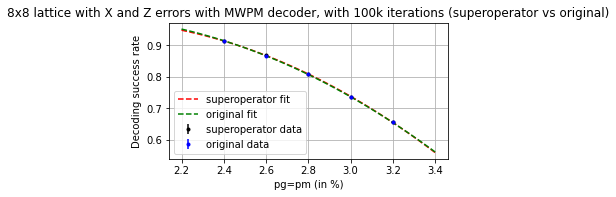

In [55]:


# 100k iterations union find, sweeping over error rates, 8X8 lattices
super8x8 = np.array([0.91377, 0.86901, 0.81006, 0.73659, 0.65606])
original8x8 = np.array([0.91455, 0.868, 0.80849, 0.73488, 0.6559])
rates = np.array([2.4, 2.6, 2.8, 3.0, 3.2])

def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

def err(x):
    return math.sqrt(x*(1-x)/9999)
error_super = [err(x) for x in super8x8]
error_original = [err(x) for x in original8x8]

rng = np.random.default_rng()
popt_super, pcov_super = curve_fit(fitting_function, rates, super8x8)
popt_original, pcov_original = curve_fit(fitting_function, rates, original8x8)

fig = plt.figure(figsize=(5,2.5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('8x8 lattice with X and Z errors with MWPM decoder, with 100k iterations (superoperator vs original)')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('pg=pm (in %)')
plt.grid()

plt.errorbar(rates,super8x8,yerr=error_super, fmt='k.')
plt.plot(np.linspace(2.2, 3.4, 100),fitting_function(np.linspace(2.2, 3.4, 100),popt_super[0],popt_super[1],popt_super[2],popt_super[3],popt_super[4]),'r--', label='superoperator')

plt.errorbar(rates,original8x8,yerr=error_original,fmt='b.')
plt.plot(np.linspace(2.2, 3.4, 100),fitting_function(np.linspace(2.2, 3.4, 100),popt_original[0],popt_original[1],popt_original[2],popt_original[3],popt_original[4]),'g--', label='original')
plt.legend(['superoperator fit','original fit','superoperator data','original data'])
plt.savefig('comparison.pdf')


In [32]:
{(4, 4): [0.84653], (5, 5): [0.93858], (6, 6): [0.9086], (7, 7): [0.95859], (8, 8): [0.93973]} # Original
{(4, 4): [0.84479], (5, 5): [0.93904], (6, 6): [0.90901], (7, 7): [0.95795], (8, 8): [0.93995]} # Super

In [3]:
# create_phenomenological_weight_3_toric_superoperator(1,0.9, [0.005,0.005,0.005,0.005,0.005,0.005])
# create_phenomenological_weight_3_toric_superoperator(1,0.9, [0.01,0.01,0.01,0.01,0.01,0.01])
# create_phenomenological_weight_3_toric_superoperator(1,0.9, [0.015,0.015,0.015,0.015,0.015,0.015])
# create_phenomenological_weight_3_toric_superoperator(1,0.9, [0.02,0.02,0.02,0.02,0.02,0.02])
# create_phenomenological_weight_3_toric_superoperator(1,0.9, [0.025,0.025,0.025,0.025,0.025,0.025])
# create_phenomenological_weight_3_toric_superoperator(1,0.9, [0.03,0.03,0.03,0.03,0.03,0.03])
# create_phenomenological_weight_3_toric_superoperator(1,0.9, [0.035,0.035,0.035,0.035,0.035,0.035])
# create_phenomenological_weight_3_toric_superoperator(1,0.9, [0.04,0.04,0.04,0.04,0.04,0.04])
create_phenomenological_weight_3_toric_superoperator(1, [0.05,0.05,0.05,0.05,0.05,0.05])

ValueError: All arrays must be of the same length

## Weight-3 vs phenomenological

In [15]:
p_bitflip = 0.05
p_phaseflip = 0.05
p_bitflip_plaq = 0.05
p_bitflip_star = 0.05

benchmarker = BenchmarkDecoder({
        "decode": ["duration", "value_to_list"],
        "correct_edge": "count_calls",})

code, decoder = initialize((4,4), "toric", "unionfind", enabled_errors=["pauli"], plotting=False, initial_states=(0,0), faulty_measurements=True)
print(run(code, decoder, iterations=2000, error_rates={"p_bitflip": p_bitflip, "p_phaseflip": p_phaseflip, "p_bitflip_plaq": p_bitflip_plaq, "p_bitflip_star": p_bitflip_star}, decode_initial=False, benchmark=benchmarker))
print(benchmarker.data)
# %lprun -f run run(code, decoder, iterations=10, decode_initial=False)

Running iteration 2000/2000
{'no_error': 796, 'benchmark': {'decoded': 2000, 'iterations': 2000, 'seed': 5811.743537, 'duration/decode/mean': 0.0016770700500019302, 'duration/decode/std': 0.0014941176013230164, 'count_calls/correct_edge/mean': 11.7955, 'count_calls/correct_edge/std': 3.157796660648054}}
{'decoded': 2000, 'iterations': 2000, 'seed': 5811.743537}


In [43]:
code, decoder = initialize((4,4), "weight_3_toric", "unionfind", plotting=False, superoperator_enable=True, sup_op_file="phenomenological_wt_3_toric_px_0.05_pz_0.05_prx_0.05_prz_0.05_pmx_0.05_pmz_0.05_ghz_1.csv", initial_states=(0,0))
benchmarker = BenchmarkDecoder({
        "decode": ["duration", "value_to_list"],
        "correct_edge": "count_calls",})
print(run(code, decoder, iterations=100, decode_initial=False, benchmark=benchmarker, seed=10))

Running iteration 100/100
{'no_error': 50, 'benchmark': {'decoded': 100, 'iterations': 100, 'seed': 100.0, 'duration/decode/mean': 0.0015184300001419614, 'duration/decode/std': 0.00048373419095903156, 'count_calls/correct_edge/mean': 11.96, 'count_calls/correct_edge/std': 2.9220540720527404}}


: 

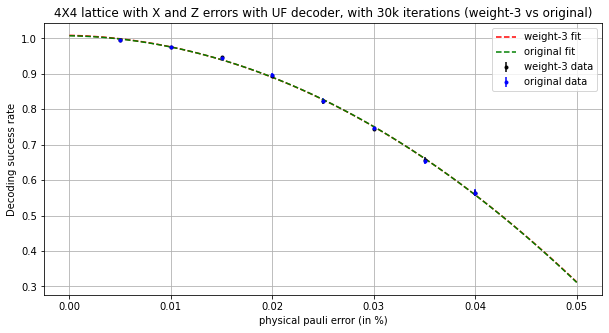

In [35]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import math

weight_3 = np.array([0.9945666667, 0.9770333333, 0.9465333333, 0.8950666667, 0.8226666667, 0.7457333333, 0.6566, 0.5643666667])

original = np.array([0.9946666666666667, 0.9762833333333333, 0.9440833333333334, 0.8974833333333333, 0.8236833333333333, 0.7462, 0.6551666666666667, 0.5647333333333333])
rates = np.array([0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04])
iterations = 30000

def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

def err(x):
    return math.sqrt((x**2 * (1-x) + x * (1-x)**2 )/3000)
error_wt_3 = [err(x) for x in weight_3]
error_original = [err(x) for x in original]

rng = np.random.default_rng()
popt_super, pcov_super = curve_fit(fitting_function, rates, weight_3)
popt_original, pcov_original = curve_fit(fitting_function, rates, original)

fig = plt.figure(figsize=(10,5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('4X4 lattice with X and Z errors with UF decoder, with 30k iterations (weight-3 vs original)')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('physical pauli error (in %)')
plt.grid()

plt.errorbar(rates,weight_3,yerr=error_wt_3, fmt='k.')
plt.plot(np.linspace(0.0, 0.05, 100),fitting_function(np.linspace(0.0, 0.05, 100),popt_super[0],popt_super[1],popt_super[2],popt_super[3],popt_super[4]),'r--', label='superoperator')

plt.errorbar(rates,original,yerr=error_original,fmt='b.')
plt.plot(np.linspace(0.0, 0.05, 100),fitting_function(np.linspace(0.0, 0.05, 100),popt_original[0],popt_original[1],popt_original[2],popt_original[3],popt_original[4]),'g--', label='original')
plt.legend(['weight-3 fit','original fit','weight-3 data','original data'])
plt.savefig('comparison.pdf')


# Supercomputer data calculations for phenomenological noise verification

## Threshold for weight 0 phenomenological

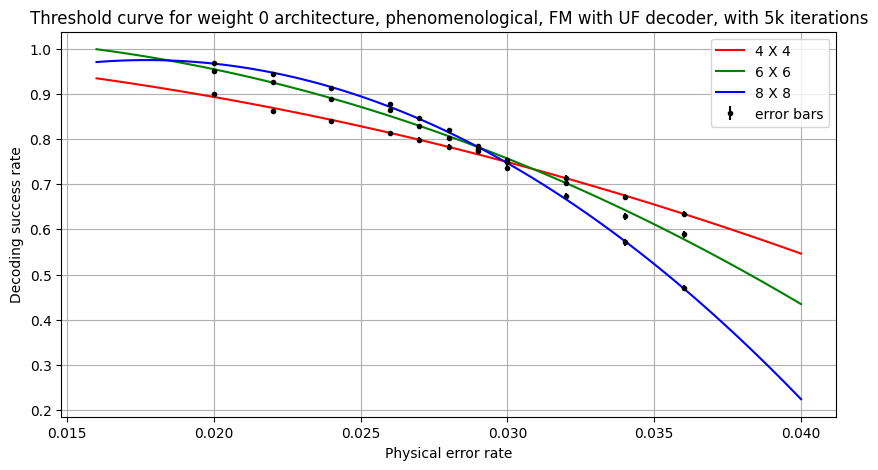

In [11]:
rates = np.array([0.020, 0.022, 0.024, 0.026, 0.027, 0.028, 0.029, 0.030, 0.032, 0.034, 0.036])
iterations = 5000

wt0_l4= np.array([4495,4314,4195,4065,3991,3913,3865,3751,3565,3357,3175])/iterations
wt0_l6= np.array([4752, 4636, 4447, 4319, 4143, 4008, 3920,3766, 3519, 3143, 2944])/iterations
wt0_l8 = np.array([4840, 4723, 4563, 4390, 4229, 4101, 3891,3682, 3365, 2855, 2353])/iterations

# Fitting function
def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

# Error function
def err(x):
    return math.sqrt((x**2 * (1-x) + x * (1-x)**2 )/iterations)


error_wt0_l4 = [err(x) for x in wt0_l4]
error_wt0_l6 = [err(x) for x in wt0_l6]
error_wt0_l8 = [err(x) for x in wt0_l8]

rng = np.random.default_rng()

popt_wt0_l4, pcov_wt0_l4 = curve_fit(fitting_function, rates, wt0_l4, maxfev = 5000)
popt_wt0_l6, pcov_wt0_l6 = curve_fit(fitting_function, rates, wt0_l6, maxfev = 5000)
popt_wt0_l8, pcov_wt0_l8 = curve_fit(fitting_function, rates, wt0_l8, maxfev = 5000)

fig = plt.figure(figsize=(10,5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('Threshold curve for weight 0 architecture, phenomenological, FM with UF decoder, with 5k iterations')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('Physical error rate')
plt.grid()

plt.errorbar(rates,wt0_l4,yerr=error_wt0_l4, fmt='k.')
plt.errorbar(rates,wt0_l6,yerr=error_wt0_l6, fmt='k.')
plt.errorbar(rates,wt0_l8,yerr=error_wt0_l8, fmt='k.')

plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),popt_wt0_l4[0],popt_wt0_l4[1],popt_wt0_l4[2],popt_wt0_l4[3],popt_wt0_l4[4]),'r-', label='wt0_l4_fit')
plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),popt_wt0_l6[0],popt_wt0_l6[1],popt_wt0_l6[2],popt_wt0_l6[3],popt_wt0_l6[4]),'g-', label='wt0_l6_fit')
plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),popt_wt0_l8[0],popt_wt0_l8[1],popt_wt0_l8[2],popt_wt0_l8[3],popt_wt0_l8[4]),'b-', label='wt0_l8_fit')

plt.legend(['4 X 4','6 X 6','8 X 8','error bars'])

plt.savefig('Threshold_wt_0_phenomenological.pdf')
plt.show()

## Error rates comparison for various architectures (Default layers)

In [ ]:
iterations = 10000

wt_0_data = {"(6, 6)":{"0":[0.02,0.9463],"1":[0.024,0.8914],"2":[0.026,0.8522],"3":[0.028,0.8108],"4":[0.03,0.7474],"5":[0.032,0.6979]},"(10, 10)":{"0":[0.02,0.9817],"1":[0.024,0.9288],"2":[0.026,0.878],"3":[0.028,0.8073],"4":[0.03,0.7163],"5":[0.032,0.5893]}}
wt_3_data = {"(6, 6)":{"0":[0.02,0.8865],"1":[0.024,0.7856],"2":[0.026,0.7399],"3":[0.028,0.6693],"4":[0.03,0.6031],"5":[0.032,0.5482]},"(10, 10)":{"0":[0.02,0.9134],"1":[0.024,0.7498],"2":[0.026,0.6458],"3":[0.028,0.5319],"4":[0.03,0.4091],"5":[0.032,0.3187]}}
wt_4_data = {"(6, 6)":{"0":[0.02,0.8688],"1":[0.024,0.7549],"2":[0.026,0.7067],"3":[0.028,0.6361],"4":[0.03,0.5727],"5":[0.032,0.5065]},"(10, 10)":{"0":[0.02,0.8742],"1":[0.024,0.6837],"2":[0.026,0.5724],"3":[0.028,0.4482],"4":[0.03,0.3414],"5":[0.032,0.2593]}}

rates = [rate[0] for rate in list(wt_0_data["(6, 6)"].values())]

wt_0_l6 = [rate[1] for rate in list(wt_0_data["(6, 6)"].values())]
wt_0_l10 = [rate[1] for rate in list(wt_0_data["(10, 10)"].values())]

wt_3_l6 = [rate[1] for rate in list(wt_3_data["(6, 6)"].values())]
wt_3_l10 = [rate[1] for rate in list(wt_3_data["(10, 10)"].values())]

wt_4_l6 = [rate[1] for rate in list(wt_4_data["(6, 6)"].values())]
wt_4_l10 = [rate[1] for rate in list(wt_4_data["(10, 10)"].values())]


# Fitting function
def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

# Error function
def err(x):
    return math.sqrt((x**2 * (1-x) + x * (1-x)**2 )/iterations)


error_wt0 = [[err(x) for x in wt0_l] for wt0_l in [wt_0_l6, wt_0_l10]]
error_wt3 = [[err(x) for x in wt3_l] for wt3_l in [wt_3_l6, wt_3_l10]]
error_wt4 = [[err(x) for x in wt4_l] for wt4_l in [wt_4_l6, wt_4_l10]]

rng = np.random.default_rng()

pop_wt0 =[curve_fit(fitting_function, rates, wt0, maxfev=5000) for wt0 in [wt_0_l6, wt_0_l10]]
pop_wt3 =[curve_fit(fitting_function, rates, wt3, maxfev=5000) for wt3 in [wt_3_l6, wt_3_l10]]
pop_wt4 =[curve_fit(fitting_function, rates, wt4, maxfev=5000) for wt4 in [wt_4_l6, wt_4_l10]]


fig = plt.figure(figsize=(10,5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('Error rate curve for diff. architectures, phenomenological, FM with UF decoder, with 10k iterations')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('Physical error rate')
plt.grid()

plt.errorbar(rates,wt_0_l6,yerr=error_wt0[0], fmt='k.')
plt.errorbar(rates,wt_0_l10,yerr=error_wt0[1], fmt='k.')

plt.errorbar(rates,wt_3_l6,yerr=error_wt3[0], fmt='k.')
plt.errorbar(rates,wt_3_l10,yerr=error_wt3[1], fmt='k.')

plt.errorbar(rates,wt_4_l6,yerr=error_wt4[0], fmt='k.')
plt.errorbar(rates,wt_4_l10,yerr=error_wt4[1], fmt='k.')

plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt0[0][0][0],pop_wt0[0][0][1],pop_wt0[0][0][2],pop_wt0[0][0][3],pop_wt0[0][0][4]),'r--', label='wt0_l6_fit')
plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt0[1][0][0],pop_wt0[1][0][1],pop_wt0[1][0][2],pop_wt0[1][0][3],pop_wt0[1][0][4]),'r-', label='wt0_l10_fit')

plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt3[0][0][0],pop_wt3[0][0][1],pop_wt3[0][0][2],pop_wt3[0][0][3],pop_wt3[0][0][4]),'g--', label='wt3_l6_fit')
plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt3[1][0][0],pop_wt3[1][0][1],pop_wt3[1][0][2],pop_wt3[1][0][3],pop_wt3[1][0][4]),'g-', label='wt3_l10_fit')

plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt4[0][0][0],pop_wt4[0][0][1],pop_wt4[0][0][2],pop_wt4[0][0][3],pop_wt4[0][0][4]),'b--', label='wt4_l6_fit')
plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt4[1][0][0],pop_wt4[1][0][1],pop_wt4[1][0][2],pop_wt4[1][0][3],pop_wt4[1][0][4]),'b-', label='wt4_l10_fit')



plt.legend(['Wt.0: 6 X 6','Wt.0 10 X 10','Wt.3: 6 X 6','Wt.3 10 X 10','Wt.4: 6 X 6','Wt.4 10 X 10','error bars'])

plt.savefig('Architectures comparison_default_layers.pdf')
plt.show()

## Original vs Weight 0 (Default Layers)

c:\Users\ssingh8\Anaconda3\envs\qsurf\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


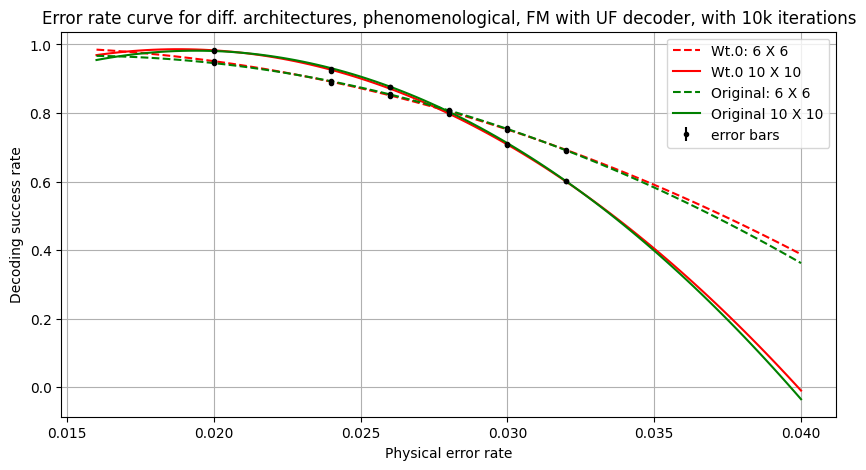

In [30]:
iterations = 10000

wt_0_data = {"(6, 6)":{"0":[0.02,0.9523],"1":[0.024,0.8889],"2":[0.026,0.8505],"3":[0.028,0.8046],"4":[0.03,0.7574],"5":[0.032,0.6889]},"(10, 10)":{"0":[0.02,0.9831],"1":[0.024,0.9232],"2":[0.026,0.8759],"3":[0.028,0.7963],"4":[0.03,0.7065],"5":[0.032,0.6006]}}
wt_00_data = {"(6, 6)":{"0":[0.02,0.9447],"1":[0.024,0.8947],"2":[0.026,0.8541],"3":[0.028,0.8069],"4":[0.03,0.7509],"5":[0.032,0.6927]},"(10, 10)":{"0":[0.02,0.9815],"1":[0.024,0.929],"2":[0.026,0.8752],"3":[0.028,0.8082],"4":[0.03,0.7104],"5":[0.032,0.6004]}}

rates = [rate[0] for rate in list(wt_0_data["(6, 6)"].values())]

wt_0_l6 = [rate[1] for rate in list(wt_0_data["(6, 6)"].values())]
wt_0_l10 = [rate[1] for rate in list(wt_0_data["(10, 10)"].values())]

wt_00_l6 = [rate[1] for rate in list(wt_00_data["(6, 6)"].values())]
wt_00_l10 = [rate[1] for rate in list(wt_00_data["(10, 10)"].values())]



# Fitting function
def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

# Error function
def err(x):
    return math.sqrt((x**2 * (1-x) + x * (1-x)**2 )/iterations)


error_wt0 = [[err(x) for x in wt0_l] for wt0_l in [wt_0_l6, wt_0_l10]]
error_wt00 = [[err(x) for x in wt00_l] for wt00_l in [wt_00_l6, wt_00_l10]]

rng = np.random.default_rng()

pop_wt0 =[curve_fit(fitting_function, rates, wt0, maxfev=5000) for wt0 in [wt_0_l6, wt_0_l10]]
pop_wt00 =[curve_fit(fitting_function, rates, wt00, maxfev=5000) for wt00 in [wt_00_l6, wt_00_l10]]


fig = plt.figure(figsize=(10,5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('Error rate curve for diff. architectures, phenomenological, FM with UF decoder, with 10k iterations')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('Physical error rate')
plt.grid()

plt.errorbar(rates,wt_0_l6,yerr=error_wt0[0], fmt='k.')
plt.errorbar(rates,wt_0_l10,yerr=error_wt0[1], fmt='k.')

plt.errorbar(rates,wt_00_l6,yerr=error_wt00[0], fmt='k.')
plt.errorbar(rates,wt_00_l10,yerr=error_wt00[1], fmt='k.')


plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt0[0][0][0],pop_wt0[0][0][1],pop_wt0[0][0][2],pop_wt0[0][0][3],pop_wt0[0][0][4]),'r--', label='wt0_l6_fit')
plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt0[1][0][0],pop_wt0[1][0][1],pop_wt0[1][0][2],pop_wt0[1][0][3],pop_wt0[1][0][4]),'r-', label='wt0_l10_fit')

plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt00[0][0][0],pop_wt00[0][0][1],pop_wt00[0][0][2],pop_wt00[0][0][3],pop_wt00[0][0][4]),'g--', label='wt00_l6_fit')
plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt00[1][0][0],pop_wt00[1][0][1],pop_wt00[1][0][2],pop_wt00[1][0][3],pop_wt00[1][0][4]),'g-', label='wt00_l10_fit')




plt.legend(['Wt.0: 6 X 6','Wt.0 10 X 10','Original: 6 X 6','Original 10 X 10','error bars'])

plt.savefig('Architectures_original_vs_wt0_comparison_default_layers.pdf')
plt.show()

## Original vs Weight 0 (20 Layers)

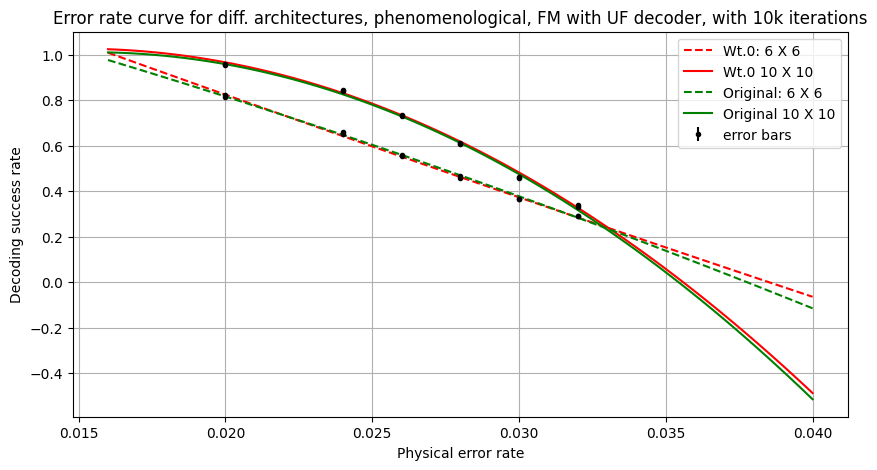

In [31]:
iterations = 10000

wt_0_data = {"(6, 6)":{"0":[0.02,0.8211],"1":[0.024,0.6506],"2":[0.026,0.5544],"3":[0.028,0.4573],"4":[0.03,0.3638],"5":[0.032,0.2919]},"(10, 10)":{"0":[0.02,0.9606],"1":[0.024,0.8458],"2":[0.026,0.7366],"3":[0.028,0.6128],"4":[0.03,0.4635],"5":[0.032,0.3407]}}
wt_00_data = {"(6, 6)":{"0":[0.02,0.8122],"1":[0.024,0.6597],"2":[0.026,0.5581],"3":[0.028,0.4663],"4":[0.03,0.3675],"5":[0.032,0.2917]},"(10, 10)":{"0":[0.02,0.9534],"1":[0.024,0.8388],"2":[0.026,0.7298],"3":[0.028,0.6095],"4":[0.03,0.4576],"5":[0.032,0.3294]}}

rates = [rate[0] for rate in list(wt_0_data["(6, 6)"].values())]

wt_0_l6 = [rate[1] for rate in list(wt_0_data["(6, 6)"].values())]
wt_0_l10 = [rate[1] for rate in list(wt_0_data["(10, 10)"].values())]

wt_00_l6 = [rate[1] for rate in list(wt_00_data["(6, 6)"].values())]
wt_00_l10 = [rate[1] for rate in list(wt_00_data["(10, 10)"].values())]



# Fitting function
def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

# Error function
def err(x):
    return math.sqrt((x**2 * (1-x) + x * (1-x)**2 )/iterations)


error_wt0 = [[err(x) for x in wt0_l] for wt0_l in [wt_0_l6, wt_0_l10]]
error_wt00 = [[err(x) for x in wt00_l] for wt00_l in [wt_00_l6, wt_00_l10]]

rng = np.random.default_rng()

pop_wt0 =[curve_fit(fitting_function, rates, wt0, maxfev=5000) for wt0 in [wt_0_l6, wt_0_l10]]
pop_wt00 =[curve_fit(fitting_function, rates, wt00, maxfev=5000) for wt00 in [wt_00_l6, wt_00_l10]]


fig = plt.figure(figsize=(10,5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('Error rate curve for diff. architectures, phenomenological, FM with UF decoder, with 10k iterations')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('Physical error rate')
plt.grid()

plt.errorbar(rates,wt_0_l6,yerr=error_wt0[0], fmt='k.')
plt.errorbar(rates,wt_0_l10,yerr=error_wt0[1], fmt='k.')

plt.errorbar(rates,wt_00_l6,yerr=error_wt00[0], fmt='k.')
plt.errorbar(rates,wt_00_l10,yerr=error_wt00[1], fmt='k.')


plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt0[0][0][0],pop_wt0[0][0][1],pop_wt0[0][0][2],pop_wt0[0][0][3],pop_wt0[0][0][4]),'r--', label='wt0_l6_fit')
plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt0[1][0][0],pop_wt0[1][0][1],pop_wt0[1][0][2],pop_wt0[1][0][3],pop_wt0[1][0][4]),'r-', label='wt0_l10_fit')

plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt00[0][0][0],pop_wt00[0][0][1],pop_wt00[0][0][2],pop_wt00[0][0][3],pop_wt00[0][0][4]),'g--', label='wt00_l6_fit')
plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt00[1][0][0],pop_wt00[1][0][1],pop_wt00[1][0][2],pop_wt00[1][0][3],pop_wt00[1][0][4]),'g-', label='wt00_l10_fit')




plt.legend(['Wt.0: 6 X 6','Wt.0 10 X 10','Original: 6 X 6','Original 10 X 10','error bars'])

plt.savefig('Architectures_original_vs_wt0_comparison_20_layers.pdf')
plt.show()

## Error rates comparison for various architectures (Layers = 20)

c:\Users\ssingh8\Anaconda3\envs\qsurf\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


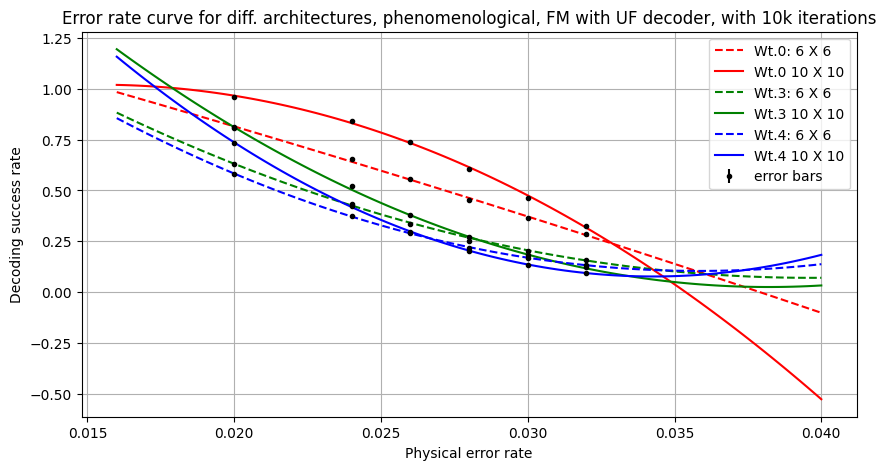

In [14]:
iterations = 10000
# LAYERS = 20, DATA

wt_0_data = {"(6, 6)":{"0":[0.02,0.8104],"1":[0.024,0.6525],"2":[0.026,0.5557],"3":[0.028,0.4518],"4":[0.03,0.365],"5":[0.032,0.2865]},"(10, 10)":{"0":[0.02,0.9606],"1":[0.024,0.8434],"2":[0.026,0.7392],"3":[0.028,0.6038],"4":[0.03,0.4611],"5":[0.032,0.3271]}}
wt_3_data = {"(6, 6)":{"0":[0.02,0.6299],"1":[0.024,0.4308],"2":[0.026,0.3352],"3":[0.028,0.2708],"4":[0.03,0.2015],"5":[0.032,0.1568]},"(10, 10)":{"0":[0.02,0.8046],"1":[0.024,0.5225],"2":[0.026,0.3785],"3":[0.028,0.2522],"4":[0.03,0.1841],"5":[0.032,0.1225]}}
wt_4_data = {"(6, 6)":{"0":[0.02,0.5814],"1":[0.024,0.3756],"2":[0.026,0.2883],"3":[0.028,0.2179],"4":[0.03,0.1672],"5":[0.032,0.1338]},"(10, 10)":{"0":[0.02,0.7351],"1":[0.024,0.4214],"2":[0.026,0.2971],"3":[0.028,0.2024],"4":[0.03,0.134],"5":[0.032,0.0946]}}

rates = [rate[0] for rate in list(wt_0_data["(6, 6)"].values())]

wt_0_l6 = [rate[1] for rate in list(wt_0_data["(6, 6)"].values())]
wt_0_l10 = [rate[1] for rate in list(wt_0_data["(10, 10)"].values())]

wt_3_l6 = [rate[1] for rate in list(wt_3_data["(6, 6)"].values())]
wt_3_l10 = [rate[1] for rate in list(wt_3_data["(10, 10)"].values())]

wt_4_l6 = [rate[1] for rate in list(wt_4_data["(6, 6)"].values())]
wt_4_l10 = [rate[1] for rate in list(wt_4_data["(10, 10)"].values())]


# Fitting function
def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

# Error function
def err(x):
    return math.sqrt((x**2 * (1-x) + x * (1-x)**2 )/iterations)


error_wt0 = [[err(x) for x in wt0_l] for wt0_l in [wt_0_l6, wt_0_l10]]
error_wt3 = [[err(x) for x in wt3_l] for wt3_l in [wt_3_l6, wt_3_l10]]
error_wt4 = [[err(x) for x in wt4_l] for wt4_l in [wt_4_l6, wt_4_l10]]

rng = np.random.default_rng()

pop_wt0 =[curve_fit(fitting_function, rates, wt0, maxfev=5000) for wt0 in [wt_0_l6, wt_0_l10]]
pop_wt3 =[curve_fit(fitting_function, rates, wt3, maxfev=5000) for wt3 in [wt_3_l6, wt_3_l10]]
pop_wt4 =[curve_fit(fitting_function, rates, wt4, maxfev=5000) for wt4 in [wt_4_l6, wt_4_l10]]


fig = plt.figure(figsize=(10,5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('Error rate curve for diff. architectures, phenomenological, FM with UF decoder, with 10k iterations')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('Physical error rate')
plt.grid()

plt.errorbar(rates,wt_0_l6,yerr=error_wt0[0], fmt='k.')
plt.errorbar(rates,wt_0_l10,yerr=error_wt0[1], fmt='k.')

plt.errorbar(rates,wt_3_l6,yerr=error_wt3[0], fmt='k.')
plt.errorbar(rates,wt_3_l10,yerr=error_wt3[1], fmt='k.')

plt.errorbar(rates,wt_4_l6,yerr=error_wt4[0], fmt='k.')
plt.errorbar(rates,wt_4_l10,yerr=error_wt4[1], fmt='k.')

plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt0[0][0][0],pop_wt0[0][0][1],pop_wt0[0][0][2],pop_wt0[0][0][3],pop_wt0[0][0][4]),'r--', label='wt0_l6_fit')
plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt0[1][0][0],pop_wt0[1][0][1],pop_wt0[1][0][2],pop_wt0[1][0][3],pop_wt0[1][0][4]),'r-', label='wt0_l10_fit')

plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt3[0][0][0],pop_wt3[0][0][1],pop_wt3[0][0][2],pop_wt3[0][0][3],pop_wt3[0][0][4]),'g--', label='wt3_l6_fit')
plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt3[1][0][0],pop_wt3[1][0][1],pop_wt3[1][0][2],pop_wt3[1][0][3],pop_wt3[1][0][4]),'g-', label='wt3_l10_fit')

plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt4[0][0][0],pop_wt4[0][0][1],pop_wt4[0][0][2],pop_wt4[0][0][3],pop_wt4[0][0][4]),'b--', label='wt4_l6_fit')
plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt4[1][0][0],pop_wt4[1][0][1],pop_wt4[1][0][2],pop_wt4[1][0][3],pop_wt4[1][0][4]),'b-', label='wt4_l10_fit')



plt.legend(['Wt.0: 6 X 6','Wt.0 10 X 10','Wt.3: 6 X 6','Wt.3 10 X 10','Wt.4: 6 X 6','Wt.4 10 X 10','error bars'])

plt.savefig('Architectures comparison_20layers.pdf')
plt.show()

## Architecture comparisons with Perfect Measurements (Layer = 1)

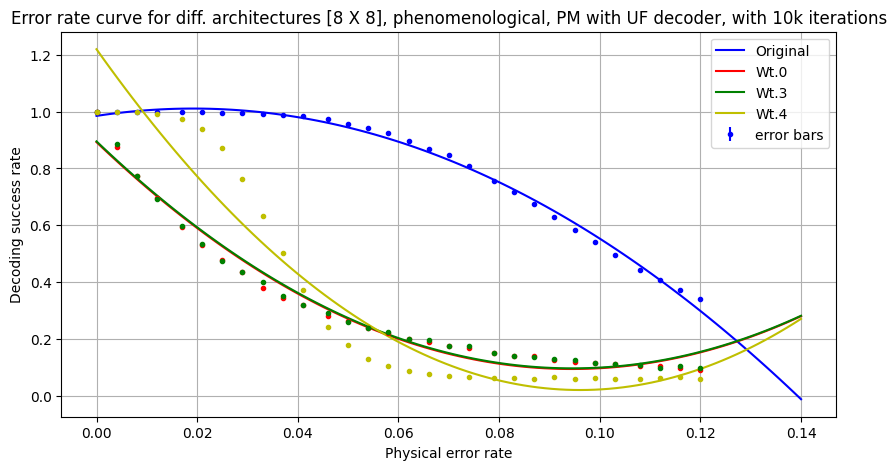

In [4]:
iterations = 10000
# LAYERS = 1, Lattice: 8 X 8 
wt_00_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.004,0.9984],"2":[0.008,0.9984],"3":[0.012,0.9984],"4":[0.017,0.9983],"5":[0.021,0.9976],"6":[0.025,0.9968],"7":[0.029,0.9955],"8":[0.033,0.9933],"9":[0.037,0.9873],"10":[0.041,0.9836],"11":[0.046,0.9729],"12":[0.05,0.9579],"13":[0.054,0.9412],"14":[0.058,0.924],"15":[0.062,0.8954],"16":[0.066,0.8702],"17":[0.07,0.847],"18":[0.074,0.8077],"19":[0.079,0.7567],"20":[0.083,0.7162],"21":[0.087,0.6748],"22":[0.091,0.6297],"23":[0.095,0.5849],"24":[0.099,0.5413],"25":[0.103,0.4969],"26":[0.108,0.4444],"27":[0.112,0.4073],"28":[0.116,0.371],"29":[0.12,0.3393]}}
wt_0_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.004,0.876],"2":[0.008,0.7727],"3":[0.012,0.6962],"4":[0.017,0.5928],"5":[0.021,0.531],"6":[0.025,0.4788],"7":[0.029,0.4346],"8":[0.033,0.3788],"9":[0.037,0.3429],"10":[0.041,0.3188],"11":[0.046,0.2822],"12":[0.05,0.2641],"13":[0.054,0.2376],"14":[0.058,0.2225],"15":[0.062,0.2018],"16":[0.066,0.1901],"17":[0.07,0.1752],"18":[0.074,0.1688],"19":[0.079,0.1525],"20":[0.083,0.142],"21":[0.087,0.1396],"22":[0.091,0.1253],"23":[0.095,0.1175],"24":[0.099,0.1168],"25":[0.103,0.111],"26":[0.108,0.1036],"27":[0.112,0.1047],"28":[0.116,0.0985],"29":[0.12,0.0915]}}
wt_3_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.004,0.8852],"2":[0.008,0.7735],"3":[0.012,0.6914],"4":[0.017,0.5962],"5":[0.021,0.5345],"6":[0.025,0.4747],"7":[0.029,0.4351],"8":[0.033,0.3993],"9":[0.037,0.3509],"10":[0.041,0.3185],"11":[0.046,0.2903],"12":[0.05,0.2617],"13":[0.054,0.2381],"14":[0.058,0.2246],"15":[0.062,0.2014],"16":[0.066,0.1971],"17":[0.07,0.176],"18":[0.074,0.1747],"19":[0.079,0.1512],"20":[0.083,0.1413],"21":[0.087,0.1367],"22":[0.091,0.1306],"23":[0.095,0.1264],"24":[0.099,0.115],"25":[0.103,0.1121],"26":[0.108,0.1071],"27":[0.112,0.0984],"28":[0.116,0.1039],"29":[0.12,0.0983]}}
wt_4_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.004,0.9984],"2":[0.008,0.9976],"3":[0.012,0.993],"4":[0.017,0.9745],"5":[0.021,0.94],"6":[0.025,0.873],"7":[0.029,0.7645],"8":[0.033,0.6344],"9":[0.037,0.5031],"10":[0.041,0.3712],"11":[0.046,0.2432],"12":[0.05,0.1788],"13":[0.054,0.1312],"14":[0.058,0.105],"15":[0.062,0.0884],"16":[0.066,0.0768],"17":[0.07,0.0711],"18":[0.074,0.0657],"19":[0.079,0.0621],"20":[0.083,0.0632],"21":[0.087,0.0611],"22":[0.091,0.0663],"23":[0.095,0.0597],"24":[0.099,0.0636],"25":[0.103,0.0599],"26":[0.108,0.0612],"27":[0.112,0.0629],"28":[0.116,0.0663],"29":[0.12,0.0595]}}

rates = [rate[0] for rate in list(wt_0_data["(8, 8)"].values())]

wt_00 = wt_0 = [rate[1] for rate in list(wt_00_data["(8, 8)"].values())]

wt_0 = [rate[1] for rate in list(wt_0_data["(8, 8)"].values())]

wt_3 = [rate[1] for rate in list(wt_3_data["(8, 8)"].values())]

wt_4 = [rate[1] for rate in list(wt_4_data["(8, 8)"].values())]


# Fitting function
def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

# Error function
def err(x):
    return math.sqrt((x**2 * (1-x) + x * (1-x)**2 )/iterations)

error_wt00 = [err(x) for x in wt_00]
error_wt0 = [err(x) for x in wt_0]
error_wt3 = [err(x) for x in wt_3]
error_wt4 = [err(x) for x in wt_4]

rng = np.random.default_rng()

pop_wt00, _ = curve_fit(fitting_function, rates, wt_00, maxfev=5000)
pop_wt0, _ = curve_fit(fitting_function, rates, wt_0, maxfev=5000)
pop_wt3, _ = curve_fit(fitting_function, rates, wt_3, maxfev=5000)
pop_wt4, _ = curve_fit(fitting_function, rates, wt_4, maxfev=5000)


fig = plt.figure(figsize=(10,5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('Error rate curve for diff. architectures [8 X 8], phenomenological, PM with UF decoder, with 10k iterations')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('Physical error rate')
plt.grid()

plt.errorbar(rates,wt_00,yerr=error_wt0[0], fmt='b.')

plt.errorbar(rates,wt_0,yerr=error_wt0[0], fmt='r.')

plt.errorbar(rates,wt_3,yerr=error_wt3[0], fmt='g.')

plt.errorbar(rates,wt_4,yerr=error_wt4[0], fmt='y.')

plt.plot(np.linspace(0.0, 0.14, 100),fitting_function(np.linspace(0.0, 0.14, 100),pop_wt00[0],pop_wt00[1],pop_wt00[2],pop_wt00[3],pop_wt00[4]),'b-', label='wt00_fit')

plt.plot(np.linspace(0.0, 0.14, 100),fitting_function(np.linspace(0.0, 0.14, 100),pop_wt0[0],pop_wt0[1],pop_wt0[2],pop_wt0[3],pop_wt0[4]),'r-', label='wt0_fit')

plt.plot(np.linspace(0.0, 0.14, 100),fitting_function(np.linspace(0.0, 0.14, 100),pop_wt3[0],pop_wt3[1],pop_wt3[2],pop_wt3[3],pop_wt3[4]),'g-', label='wt3_fit')

plt.plot(np.linspace(0.0, 0.14, 100),fitting_function(np.linspace(0.0, 0.14, 100),pop_wt4[0],pop_wt4[1],pop_wt4[2],pop_wt4[3],pop_wt4[4]),'y-', label='wt4_fit')




plt.legend(['Original','Wt.0','Wt.3','Wt.4','error bars'])

plt.savefig('Architectures comparison_1layer_PM.pdf')
plt.show()

## Architecture comparisons with Perfect Measurements (Layer = 2)

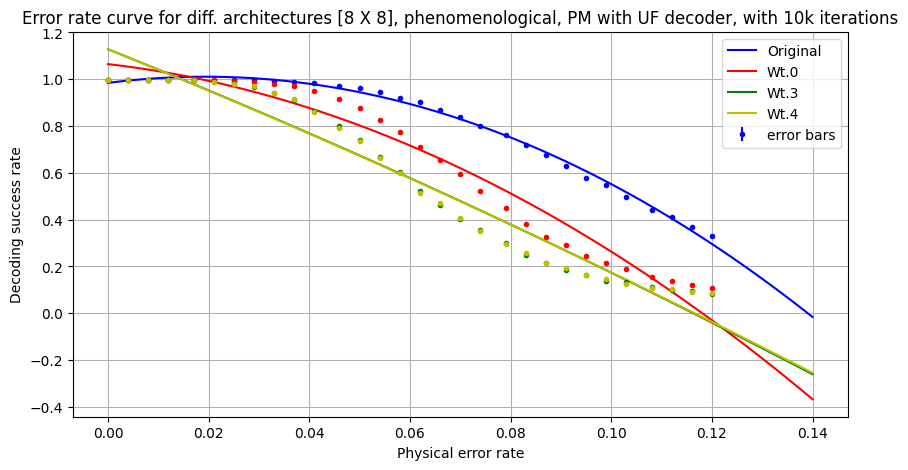

In [20]:
iterations = 10000
# LAYERS = 1, Lattice: 8 X 8 
wt_00_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.004,0.9984],"2":[0.008,0.9984],"3":[0.012,0.9983],"4":[0.017,0.9981],"5":[0.021,0.9974],"6":[0.025,0.9971],"7":[0.029,0.996],"8":[0.033,0.9921],"9":[0.037,0.9882],"10":[0.041,0.9835],"11":[0.046,0.9706],"12":[0.05,0.9611],"13":[0.054,0.9439],"14":[0.058,0.9188],"15":[0.062,0.9007],"16":[0.066,0.8677],"17":[0.07,0.8401],"18":[0.074,0.7991],"19":[0.079,0.7603],"20":[0.083,0.7199],"21":[0.087,0.6781],"22":[0.091,0.6313],"23":[0.095,0.5781],"24":[0.099,0.5472],"25":[0.103,0.497],"26":[0.108,0.4392],"27":[0.112,0.4103],"28":[0.116,0.37],"29":[0.12,0.3294]}}
wt_0_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.004,0.9984],"2":[0.008,0.9984],"3":[0.012,0.9984],"4":[0.017,0.998],"5":[0.021,0.9967],"6":[0.025,0.9943],"7":[0.029,0.9893],"8":[0.033,0.9788],"9":[0.037,0.9709],"10":[0.041,0.9507],"11":[0.046,0.9168],"12":[0.05,0.8755],"13":[0.054,0.8279],"14":[0.058,0.7732],"15":[0.062,0.7119],"16":[0.066,0.6544],"17":[0.07,0.5932],"18":[0.074,0.5213],"19":[0.079,0.4497],"20":[0.083,0.3834],"21":[0.087,0.3281],"22":[0.091,0.2928],"23":[0.095,0.2441],"24":[0.099,0.2161],"25":[0.103,0.1881],"26":[0.108,0.1568],"27":[0.112,0.1378],"28":[0.116,0.1192],"29":[0.12,0.1066]}}
wt_3_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.004,0.9984],"2":[0.008,0.9983],"3":[0.012,0.9976],"4":[0.017,0.995],"5":[0.021,0.9898],"6":[0.025,0.9834],"7":[0.029,0.9684],"8":[0.033,0.9417],"9":[0.037,0.9113],"10":[0.041,0.8629],"11":[0.046,0.8005],"12":[0.05,0.741],"13":[0.054,0.6684],"14":[0.058,0.6025],"15":[0.062,0.522],"16":[0.066,0.4642],"17":[0.07,0.4049],"18":[0.074,0.3546],"19":[0.079,0.2991],"20":[0.083,0.2485],"21":[0.087,0.2133],"22":[0.091,0.185],"23":[0.095,0.1629],"24":[0.099,0.1393],"25":[0.103,0.1321],"26":[0.108,0.1126],"27":[0.112,0.0996],"28":[0.116,0.0951],"29":[0.12,0.0813]}}
wt_4_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.004,0.9984],"2":[0.008,0.9984],"3":[0.012,0.9977],"4":[0.017,0.9953],"5":[0.021,0.9898],"6":[0.025,0.9809],"7":[0.029,0.969],"8":[0.033,0.9409],"9":[0.037,0.9152],"10":[0.041,0.8604],"11":[0.046,0.7905],"12":[0.05,0.7341],"13":[0.054,0.6636],"14":[0.058,0.6001],"15":[0.062,0.5157],"16":[0.066,0.4699],"17":[0.07,0.408],"18":[0.074,0.3521],"19":[0.079,0.2952],"20":[0.083,0.2562],"21":[0.087,0.215],"22":[0.091,0.1919],"23":[0.095,0.165],"24":[0.099,0.1469],"25":[0.103,0.1263],"26":[0.108,0.1073],"27":[0.112,0.1041],"28":[0.116,0.0903],"29":[0.12,0.0886]}}

rates = [rate[0] for rate in list(wt_0_data["(8, 8)"].values())]

wt_00 = wt_0 = [rate[1] for rate in list(wt_00_data["(8, 8)"].values())]

wt_0 = [rate[1] for rate in list(wt_0_data["(8, 8)"].values())]

wt_3 = [rate[1] for rate in list(wt_3_data["(8, 8)"].values())]

wt_4 = [rate[1] for rate in list(wt_4_data["(8, 8)"].values())]


# Fitting function
def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

# Error function
def err(x):
    return math.sqrt((x**2 * (1-x) + x * (1-x)**2 )/iterations)

error_wt00 = [err(x) for x in wt_00]
error_wt0 = [err(x) for x in wt_0]
error_wt3 = [err(x) for x in wt_3]
error_wt4 = [err(x) for x in wt_4]

rng = np.random.default_rng()

pop_wt00, _ = curve_fit(fitting_function, rates, wt_00, maxfev=5000)
pop_wt0, _ = curve_fit(fitting_function, rates, wt_0, maxfev=5000)
pop_wt3, _ = curve_fit(fitting_function, rates, wt_3, maxfev=5000)
pop_wt4, _ = curve_fit(fitting_function, rates, wt_4, maxfev=5000)


fig = plt.figure(figsize=(10,5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('Error rate curve for diff. architectures [8 X 8], phenomenological, PM with UF decoder, with 10k iterations')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('Physical error rate')
plt.grid()

plt.errorbar(rates,wt_00,yerr=error_wt0[0], fmt='b.')

plt.errorbar(rates,wt_0,yerr=error_wt0[0], fmt='r.')

plt.errorbar(rates,wt_3,yerr=error_wt3[0], fmt='g.')

plt.errorbar(rates,wt_4,yerr=error_wt4[0], fmt='y.')

plt.plot(np.linspace(0.0, 0.14, 100),fitting_function(np.linspace(0.0, 0.14, 100),pop_wt00[0],pop_wt00[1],pop_wt00[2],pop_wt00[3],pop_wt00[4]),'b-', label='wt00_fit')

plt.plot(np.linspace(0.0, 0.14, 100),fitting_function(np.linspace(0.0, 0.14, 100),pop_wt0[0],pop_wt0[1],pop_wt0[2],pop_wt0[3],pop_wt0[4]),'r-', label='wt0_fit')

plt.plot(np.linspace(0.0, 0.14, 100),fitting_function(np.linspace(0.0, 0.14, 100),pop_wt3[0],pop_wt3[1],pop_wt3[2],pop_wt3[3],pop_wt3[4]),'g-', label='wt3_fit')

plt.plot(np.linspace(0.0, 0.14, 100),fitting_function(np.linspace(0.0, 0.14, 100),pop_wt4[0],pop_wt4[1],pop_wt4[2],pop_wt4[3],pop_wt4[4]),'y-', label='wt4_fit')




plt.legend(['Original','Wt.0','Wt.3','Wt.4','error bars'])

plt.savefig('Architectures comparison_2layer_PM.pdf')
plt.show()

## Architecture comparisons with Perfect Measurements (Layers = 8)

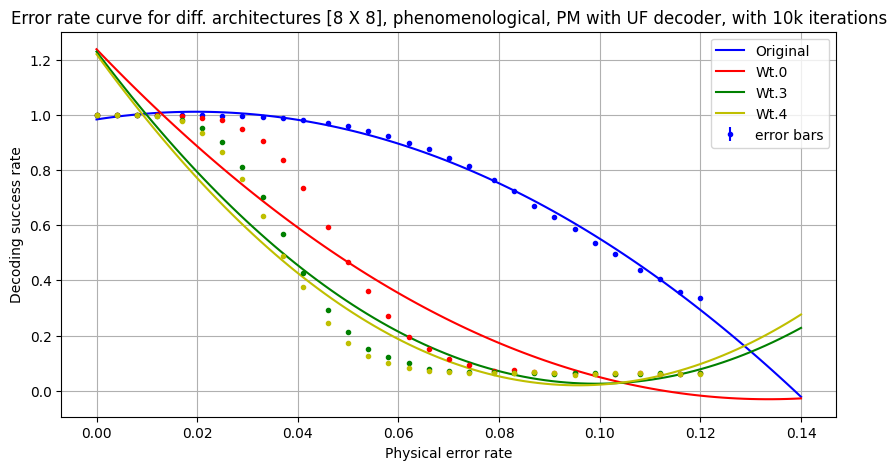

In [3]:
iterations = 10000
# LAYERS = d, Lattice: 8 X 8 
wt_00_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.004,0.9984],"2":[0.008,0.9984],"3":[0.012,0.9984],"4":[0.017,0.9983],"5":[0.021,0.9977],"6":[0.025,0.9967],"7":[0.029,0.9958],"8":[0.033,0.9923],"9":[0.037,0.9876],"10":[0.041,0.9815],"11":[0.046,0.9691],"12":[0.05,0.9601],"13":[0.054,0.9408],"14":[0.058,0.9236],"15":[0.062,0.8968],"16":[0.066,0.8749],"17":[0.07,0.843],"18":[0.074,0.8131],"19":[0.079,0.763],"20":[0.083,0.724],"21":[0.087,0.6701],"22":[0.091,0.6311],"23":[0.095,0.5844],"24":[0.099,0.5341],"25":[0.103,0.4953],"26":[0.108,0.4379],"27":[0.112,0.4037],"28":[0.116,0.3596],"29":[0.12,0.3372]}}
wt_0_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.004,0.9984],"2":[0.008,0.9984],"3":[0.012,0.9981],"4":[0.017,0.9957],"5":[0.021,0.9899],"6":[0.025,0.9812],"7":[0.029,0.95],"8":[0.033,0.9057],"9":[0.037,0.837],"10":[0.041,0.7354],"11":[0.046,0.5951],"12":[0.05,0.4652],"13":[0.054,0.3614],"14":[0.058,0.2727],"15":[0.062,0.1966],"16":[0.066,0.151],"17":[0.07,0.1148],"18":[0.074,0.0923],"19":[0.079,0.0724],"20":[0.083,0.0744],"21":[0.087,0.0663],"22":[0.091,0.0653],"23":[0.095,0.0653],"24":[0.099,0.0606],"25":[0.103,0.062],"26":[0.108,0.0645],"27":[0.112,0.0623],"28":[0.116,0.0598],"29":[0.12,0.064]}}
wt_3_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.004,0.9984],"2":[0.008,0.9979],"3":[0.012,0.9954],"4":[0.017,0.9805],"5":[0.021,0.9522],"6":[0.025,0.9027],"7":[0.029,0.8106],"8":[0.033,0.7016],"9":[0.037,0.5668],"10":[0.041,0.4256],"11":[0.046,0.2914],"12":[0.05,0.2119],"13":[0.054,0.1503],"14":[0.058,0.1218],"15":[0.062,0.0994],"16":[0.066,0.0803],"17":[0.07,0.073],"18":[0.074,0.0675],"19":[0.079,0.0691],"20":[0.083,0.066],"21":[0.087,0.063],"22":[0.091,0.061],"23":[0.095,0.0633],"24":[0.099,0.063],"25":[0.103,0.0617],"26":[0.108,0.0605],"27":[0.112,0.066],"28":[0.116,0.0605],"29":[0.12,0.063]}}
wt_4_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.004,0.9984],"2":[0.008,0.9975],"3":[0.012,0.9938],"4":[0.017,0.9766],"5":[0.021,0.9352],"6":[0.025,0.8664],"7":[0.029,0.7655],"8":[0.033,0.6333],"9":[0.037,0.4892],"10":[0.041,0.3748],"11":[0.046,0.2455],"12":[0.05,0.1744],"13":[0.054,0.1263],"14":[0.058,0.0996],"15":[0.062,0.0814],"16":[0.066,0.072],"17":[0.07,0.0696],"18":[0.074,0.0627],"19":[0.079,0.0631],"20":[0.083,0.0629],"21":[0.087,0.0681],"22":[0.091,0.063],"23":[0.095,0.0568],"24":[0.099,0.0618],"25":[0.103,0.0647],"26":[0.108,0.063],"27":[0.112,0.0625],"28":[0.116,0.0623],"29":[0.12,0.0622]}}

rates = [rate[0] for rate in list(wt_0_data["(8, 8)"].values())]

wt_00 = wt_0 = [rate[1] for rate in list(wt_00_data["(8, 8)"].values())]

wt_0 = [rate[1] for rate in list(wt_0_data["(8, 8)"].values())]

wt_3 = [rate[1] for rate in list(wt_3_data["(8, 8)"].values())]

wt_4 = [rate[1] for rate in list(wt_4_data["(8, 8)"].values())]


# Fitting function
def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

# Error function
def err(x):
    return math.sqrt((x**2 * (1-x) + x * (1-x)**2 )/iterations)

error_wt00 = [err(x) for x in wt_00]
error_wt0 = [err(x) for x in wt_0]
error_wt3 = [err(x) for x in wt_3]
error_wt4 = [err(x) for x in wt_4]

rng = np.random.default_rng()

pop_wt00, _ = curve_fit(fitting_function, rates, wt_00, maxfev=5000)
pop_wt0, _ = curve_fit(fitting_function, rates, wt_0, maxfev=5000)
pop_wt3, _ = curve_fit(fitting_function, rates, wt_3, maxfev=5000)
pop_wt4, _ = curve_fit(fitting_function, rates, wt_4, maxfev=5000)


fig = plt.figure(figsize=(10,5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('Error rate curve for diff. architectures [8 X 8], phenomenological, PM with UF decoder, with 10k iterations')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('Physical error rate')
plt.grid()

plt.errorbar(rates,wt_00,yerr=error_wt0[0], fmt='b.')

plt.errorbar(rates,wt_0,yerr=error_wt0[0], fmt='r.')

plt.errorbar(rates,wt_3,yerr=error_wt3[0], fmt='g.')

plt.errorbar(rates,wt_4,yerr=error_wt4[0], fmt='y.')

plt.plot(np.linspace(0.0, 0.14, 100),fitting_function(np.linspace(0.0, 0.14, 100),pop_wt00[0],pop_wt00[1],pop_wt00[2],pop_wt00[3],pop_wt00[4]),'b-', label='wt00_fit')

plt.plot(np.linspace(0.0, 0.14, 100),fitting_function(np.linspace(0.0, 0.14, 100),pop_wt0[0],pop_wt0[1],pop_wt0[2],pop_wt0[3],pop_wt0[4]),'r-', label='wt0_fit')

plt.plot(np.linspace(0.0, 0.14, 100),fitting_function(np.linspace(0.0, 0.14, 100),pop_wt3[0],pop_wt3[1],pop_wt3[2],pop_wt3[3],pop_wt3[4]),'g-', label='wt3_fit')

plt.plot(np.linspace(0.0, 0.14, 100),fitting_function(np.linspace(0.0, 0.14, 100),pop_wt4[0],pop_wt4[1],pop_wt4[2],pop_wt4[3],pop_wt4[4]),'y-', label='wt4_fit')




plt.legend(['Original','Wt.0','Wt.3','Wt.4','error bars'])

plt.savefig('Architectures comparison_Default_layer_PM.pdf')
plt.show()

# PLOTTING

## Bokeh Plots

In [ ]:
plot_data_address = "C:/qarch/qsurface/data/exported_data/threshold_superoperator_data.json"
file_location = "C:/qarch/qsurface/data/sim_protocol/"

# Getting the logical error rates

def plot_threshold(plotting_dict: dict, error_rates: list):
    fig = figure(title="Error threshold", x_axis_label = "Physical error rate", y_axis_label = "Logical error rate")
    for lattice, logical in plotting_dict.items():
        fig.line(error_rates, logical, legend_label=lattice, line_width=2)

    return fig


plot_data = pd.read_json(plot_data_address)
plot_data = dict(plot_data)
lattices = [str(max(tuple(l)))+"X"+str(max(tuple(l))) for l in list(plot_data.keys())]
plotting_dict = {lattice: None for lattice in lattices}
for lattice, value in zip(lattices, plot_data.values()):
    plotting_dict[lattice] = list(dict(value).values())

# Getting the error rates
error_rates = []
files = [f for f in listdir(file_location) if isfile(join(file_location, f))]
FILES = [file_location+ f for f in files]
for file in FILES:
    csv_file = pd.read_csv(file,sep=';')
    error_rates.append(csv_file.iloc[0]['pg'])

